# Getting started with Qadence

Qadence is a quantum computing SDK developed at Pasqal. It has a seamless integration with:
- Pytorch, for creating and optimizing variational circuits.
- Sympy, for integrating symbolic expressions into into the circuits.

## Quantum states

For the purpose of this hackathon, you will only work with a statevector representation of quantum states. For a system of $N$ qubits, the statevector is a $2^N$ vector corresponding to the complex amplitudes of each basis state. For example, a 2-qubit state $|\psi\rangle$ has four complex amplitudes (a, b, c, d):

$$
|\psi\rangle = a|00\rangle + b|01\rangle + c|10\rangle + d|11\rangle
$$

Qadence integrates with PyTorch, and vectors and matrices are typically represented as a `torch.tensor`, which is similar to the `ndarray` from NumPy.

Qadence has some convenience functions to initialize and process statevectors.

In [1]:
from qadence import zero_state, one_state, product_state, ghz_state, random_state

n_qubits = 3

state = zero_state(n_qubits)   # The state |000>
state = one_state(n_qubits)    # The state |111>
state = product_state("101")   # The state |101>
state = ghz_state(n_qubits)    # The state (1/√2)(|000> + |111>)
state = random_state(n_qubits) # A random 3-qubit state

In all cases above, the `state` is an 8 (2^3) entry torch tensor with the amplitude values. 

Note that often in Qadence there is an extra dimension at the start of a tensor to account for the possibility of batching many states into a single object. In this case, there is only one state being created, so the tensor size is $[1, 8]$

In [2]:
assert list(state.size()) == [1, 8]

print(state)

tensor([[ 0.1589-0.5474j, -0.1559+0.1874j, -0.1147+0.1551j,  0.2078+0.1652j,
          0.2274-0.0917j,  0.3464-0.5322j, -0.1134+0.1247j, -0.0240+0.1250j]])


We expect quantum states to be normalized, which we can check:

In [3]:
from qadence import is_normalized, normalize

print(is_normalized(state))

print(is_normalized(2.0 * state))

new_state = normalize(2.0 * state)

print(is_normalized(new_state))

True
False
True


It is often useful to compute the overlap, or inner-product, between two states $\langle \psi|\phi \rangle$. Below we construct two batches of random product states (which are computational basis states), and compute the overlap between them.

In [5]:
from qadence import rand_product_state, overlap

n_qubits = 3

batch0 = rand_product_state(n_qubits, batch_size = 10)
batch1 = rand_product_state(n_qubits, batch_size = 10)

overlap(batch0, batch1)

tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

You can find more information on qubit ordering conventions in the [State Conventions documentation page](https://pasqal-io.github.io/qadence/latest/content/state_conventions/).

## The block system

Program composition in Qadence is done with the block system. Each basic operation is a type of "block", and all blocks can be composed together to create more complex blocks. Ultimately, the full quantum circuit is a composition of blocks.

Basic primitive gates only need the target qubit as input.

In [6]:
from qadence import X, Y, Z
from qadence import chain

# A block chaining three Pauli operators
block = chain(X(0), Y(1), Z(2)) 

# The * operator is an alias for the chain() function
block = X(0) * Y(1) * Z(2)

Each block or full circuit can be visualized with the `display` function from `qadence.draw`. 

Note that this requires you to install the `graphviz` package on your system, and also the `visualization` extra (`pip install "qadence[visualization]"`). You can find more information here: [Qadence installation instructions](https://pasqal-io.github.io/qadence/latest/getting_started/installation/).



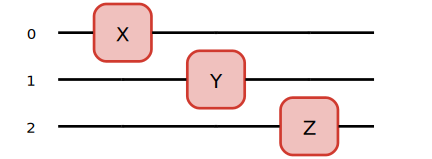

In [7]:
from qadence.draw import display

display(block)

Each operator above acts on a different qubit, and so chaining them in sequence is equivalent to combining them in parallel. Combining them in parallel is represented by the kronecker product of each operator. Explicitly calling the `kron()` is only possible when the qubit support is different.

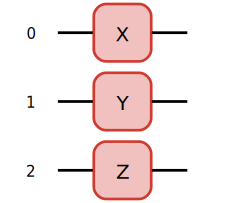

In [8]:
from qadence import kron

# A block doing the kronecker product of three Pauli operators
block = kron(X(0), Y(1), Z(2)) 

# The @ operator is an alias for the kron() function
block = X(0) @ Y(1) @ Z(2)

display(block)

Some more useful tips on the block system:

In [9]:
n_qubits = 3

# Composition functions support list comprehension syntax
block = kron(X(i) for i in range(n_qubits))

# The qubit support of any block can be inspected
assert block.qubit_support == (0, 1, 2)

# Any composite block is a tree of blocks
for block in block.blocks:
    print("Child block acting on qubits", block.qubit_support)

Child block acting on qubits (0,)
Child block acting on qubits (1,)
Child block acting on qubits (2,)


Any composite block can be equally used when composing an even more complex block. If you simply print the block, you will see an ASCII representation of the block tree:

In [10]:
from qadence import CNOT

n_qubits = 3

block = kron(X(i) for i in range(n_qubits))

new_block = chain(block, CNOT(0, 1), CNOT(1, 2))

new_block

ChainBlock(0,1,2)
├── KronBlock(0,1,2)
│   ├── X(0)
│   ├── X(1)
│   └── X(2)
├── CNOT(0, 1)
└── CNOT(1, 2)

In a statevector simulation each quantum operator acting on $N$ qubits is represented as a matrix of size $2^N\times2^N$. So far in our examples, we have only used the symbolic representation of the operators, so this matrix is not yet created (and often, it never needs to be created). Nevertheless, we can forcefully inspect it with the `tensor` method:

In [11]:
block.tensor()

tensor([[[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
         [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]]])

## Quickly running blocks

Later on we will learn how to build more complex programs with the `QuantumModel` class to target specific applications. 

However, sometimes we just want to quickly apply some operators to a statevector to inspect the result. For this purpose, Qadence supports three quick execution functions:

- `run`: returns the final statevector after running the block.
- `sample`: samples from the final statevector and returns a counter.
- `expectation`: computes the exact expectation value of an observable after running a block.

In [12]:
from qadence import X, kron, run
from qadence import product_state, overlap

n_qubits = 3

block = kron(X(i) for i in range(n_qubits))

# By default the initial state is the all-zero state
state = run(block)
assert overlap(state, product_state("111")) == 1.0

# We can change it with the state argument
init_state = product_state("010")
state = run(block, state = init_state)
assert overlap(state, product_state("101")) == 1.0

As you might know, on real hardware it is not possible to directly inspect the statevector. Instead quantum computing on real devices typically relies on repeatedly running experiments and measuring the final wavefunction to obtain samples of the basis states following the probability distribution encoded in the amplitudes. This is also called the $Z$-basis, as the states $|0\rangle$ and $|1\rangle$ are eigenvectors of the $Z$ Pauli operator:

$$
Z = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
$$

The `sample` function replicates this behaviour by performing a certain number of shots:

In [13]:
from qadence import H, CNOT, sample

n_qubits = 3

# The GHZ state (1/√2)(|000> + |111>) can be built 
# with an Hadamard gate + two CNOT gates
block = H(0) * CNOT(0, 1) * CNOT(0, 2)

sample(block, n_shots = 1000)

[OrderedCounter({'000': 503, '111': 497})]

The expectation value of a given observable $\hat{O}$ is another useful output often used in quantum computing. For a quantum state $|\psi\rangle$, that is the quantity $\langle \psi|\hat{O}|\psi \rangle$. In a statevector simulation, this can be computed exactly with a vector-matrix-vector product.

Observables are Hermitian operators, often represented as sums of Pauli operators. Sums of operators can easily be written in Qadence with the final block composition function: the `add`.

In [15]:
from qadence import expectation, add
from qadence import Z

n_qubits = 3

block = H(0) * CNOT(0, 1) * CNOT(0, 2)

obs = add(Z(i) for i in range(n_qubits))

# Or using the + operator as an alias
obs = Z(0) + Z(1) + Z(2)

expectation(block, observable = obs)

tensor([[0.]])

Clearly, the value here is 0, as we used $|\psi\rangle=\frac{1}{\sqrt{2}}(|000\rangle + |111\rangle)$ because we are computing

$$
\langle \psi|\hat{O}|\psi \rangle = \frac{1}{2}(\langle000|Z_0+Z_1+Z_2|000\rangle + \langle111|Z_0+Z_1+Z_2|111\rangle) = \frac{1}{2}(3 - 3) = 0
$$

Note that exactly computing the expectation value like we did here is not possilbe on real hardware! The most you can do is to use the samples obtained to approximate the expectation value. For $Z$ expectations this is quite direct since it is given by the probability of measuring $\ket{0}$ minus the probability of measuring $\ket{1}$, which you can estimate from the sample histogram.


## Parametric operators

Certain operators have variable parameters that can take different values. The most basic ones are the `RX`, `RY` and `RZ` which perform a rotation on a single qubit by a certain angle.

$$
R_x(\theta)=\begin{bmatrix}
\cos\frac{\theta}{2} & -i\sin\frac{\theta}{2} \\
-i\sin\frac{\theta}{2} & \cos\frac{\theta}{2}
\end{bmatrix}
\qquad
R_y(\theta)=\begin{bmatrix}
\cos\frac{\theta}{2} & -\sin\frac{\theta}{2} \\
\sin\frac{\theta}{2} & \cos\frac{\theta}{2}
\end{bmatrix}
\qquad
R_z(\theta)=\begin{bmatrix}
e^{-i\theta/2} & 0 \\
0 & e^{i\theta/2}
\end{bmatrix}
$$

In [16]:
from qadence import RX, RY, RZ, PI

angle = PI

block = RX(0, angle) * RY(1, angle) * RZ(2, angle)

For certain applications it can be useful to delay defining the value of the parameter until the program is executed. Either because the parameter will be used as a data input (feature parameter), or because we want to mark that parameter as something to be optimized depending on a given goal (variational parameter).

Both of these parameter types and fully symbolic parameter expressions are supported in Qadence through an integration with Sympy.

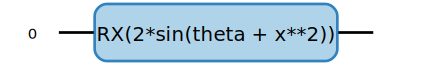

In [17]:
from qadence import FeatureParameter, VariationalParameter
from sympy import cos, sin, exp
from qadence.draw import display

x = FeatureParameter("x")
theta = VariationalParameter("theta")

param = 2*sin(x**2 + theta)

block = RX(0, param)

display(block)

To execute the block above, we need to provide a value for `x`, since we marked it as a feature parameter. This is done through the values dictionary. Typically, values need to be passed as torch tensors.

In [18]:
import torch
from qadence import expectation, Z

# Batching of various input values is supported
values = {"x": torch.tensor([0.0, 1.0, 2.0, 3.0])}

# Resulting in a batch of results, one for each input
result = expectation(block, observable = Z(0), values = values)

# The first dimension in the batch dimension
assert list(result.size()) == [4, 1]

# We can get rid of the last dimension with the squeeze() method for torch tensors
result.squeeze()

tensor([-0.0439, -0.2905, -0.3689,  0.5530])

Note that we did not need to pass a value for `theta`. This is because we marked it as a variational parameter, so it was randomly initialized to some value between 0 and 1. Nevertheless, we could override this by still including a value for it in the values dictionary.

## Running your first optimization loop

Optimizing the parameters of a variational program to achieve a certain goal is a very popular approach to problem solving. After all, that is the essence of Neural Networks (NNs).

### The PyTorch magic in a nutshell
Generally, defining a neural network model in PyTorch follows the recipe of:
- Creating a class inheriting from the `torch.nn.Module` class [(see here)](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)
- Initializing (in the `__init__`) the layers of the neural network, which represent specific linear algebra operations.
- Overriding the `forward` method to define the exact sequence of operations that will transform the input to the output.

Utilizing this recipe is essential to using the [automatic differentiation engine in PyTorch](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html). This enables efficient derivatives of the model output with respect to the model parameters and allows using gradient-based optimization for efficient neural network training.

### Quantum Neural Networks

With the popularity of classical NNs, it didn't take long before Quantum Neural Networks (QNNs) were invented. This is a general term, but typically a QNN is a variational quantum circuit and it requires three things:
- A feature map, which is a sequence of operations used to encode some classical input data into a quantum state.
- An ansatz, which is a sequence of operations with some trainable variational parameters.
- An observable, or generally some measurement procedure that defines how the output is obtained from the model.

Qadence connects with PyTorch through the `QuantumModel` class, which inherits from the `torch.nn.Module`, and allows us to use the autograd engine to train variational quantum circuits.

## The feature map

The feature map is often a sequence of rotations where the angle depends on some input data. You already learned what you need to do this manually.

In [19]:
from qadence import RX, FeatureParameter, kron

n_qubits = 3

x = FeatureParameter("x")

fm = kron(RX(i, x) for i in range(n_qubits))

However, certain applications require different tricks with the feature map, which we will not get into here, and for that the `feature_map` constructor function [(check documentation)](https://pasqal-io.github.io/qadence/latest/content/qml_constructors/) becomes useful. With the call below we get exactly the same block we just wrote above.

In [20]:
from qadence import feature_map

fm = feature_map(n_qubits, param = "x")

## The Ansatz

The ansatz is a sequence of operations that includes a few (or several) trainable parameters to be optimized. A common type of ansatz used is the so-called Hardware-Efficient-Ansatz (HEA), which is defined in layers of single-qubit rotations followed by some entangling operation (a layer of CNOTs, in the simplest case).

The `hea` function in Qadence is useful to quickly build such circuits (also described in the previous documentation page).

However, you are free to define ansatze however you want, and sometimes you don't even need that many parameters... It all depends on the structure of the problem you are trying to solve.

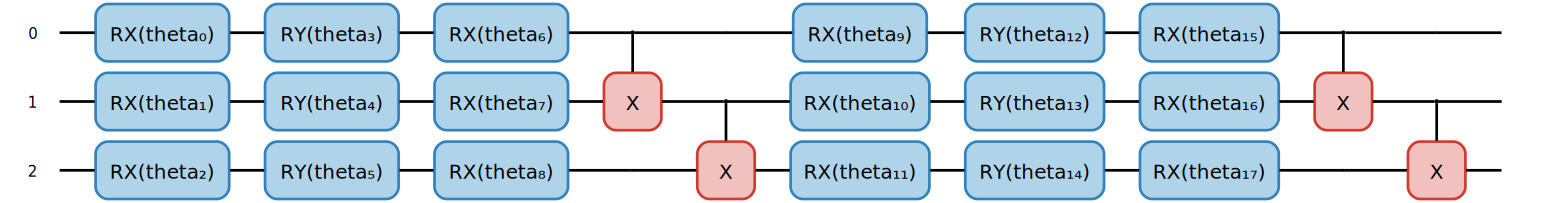

In [22]:
from qadence import hea
from qadence.draw import display

ansatz = hea(n_qubits, depth = 2)

display(ansatz)

## The QuantumCircuit

So far we have only looked at basic and composite blocks in Qadence, and in most cases we were inferring the number of qubits in the system from the qubit support of the block itself. Before moving on to the QuantumModel definition, we need to concretize the final `QuantumCircuit` where we can set the total number of qubits. In this case, this step will not change anything in our program, but we must run it either way.

In [23]:
from qadence import QuantumCircuit

block = fm * ansatz

circuit = QuantumCircuit(n_qubits, block)

## The QuantumModel

We are almost ready to define our model, we are missing only an observable to measure that will represent our output.

In [24]:
from qadence import Z, QuantumModel, add

obs = add(Z(i) for i in range(n_qubits))

model = QuantumModel(circuit, observable = obs)

Our model is ready, and we can now try to run it. Similarly to what you have seen before, the `run`, `sample`, and `expectation` functions are now available as method from the model with the same behaviour as described. To run any of them, we must pass the values to the input parameter `x` that we defined in the feature_map.

In [25]:
import torch

values = {"x": torch.tensor([0.0, 1.0, 2.0, 3.0])}

model.expectation(values)

tensor([[ 0.2992],
        [-0.4291],
        [-0.3515],
        [ 0.2506]], grad_fn=<CatBackward0>)

In this way, our model defines a function $f_\theta(x)$, parameterized by a set of $\{\theta\}$ parameters.

As you can see we now have a `grad_fn` associated with our output tensor: PyTorch know how to efficiently compute the gradient of this output.

Note: the `QuantumModel` is a `torch.nn.Module`, and thus calling `model(...)` would call the `forward(...)` method, as is standard in PyTorch. By default in the `QuantumModel` this calls `model.run(...)`, but custom models can always be created by inheriting from `QuantumModel` and overriding the `forward` method.

Note: the computational graph of a `torch.tensor` sometimes is not needed, or can cause issues when integrating with other libraries like `matplotlib`. You can remove it by calling `result.detach()`.

## Defining a problem to solve

Now that our model is ready, we need a basic optimization problem to try it out. We can try to fit a basic set of data points.

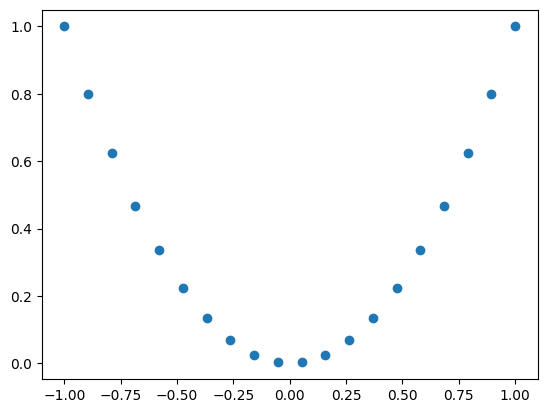

In [26]:
import matplotlib.pyplot as plt

def f(x):
    return x**2

x_train = torch.linspace(-1, 1, 20)
y_train = f(x_train)

plt.scatter(x_train, y_train)

Let's save our model output before training so we can compare it later.

In [27]:
values = {"x": x_train}

y_pred_initial = model.expectation(values).squeeze().detach()

## Training the model

We can now train our model with a basic PyTorch training loop. First, we need a loss function that encodes the goal of our problem when minimized.

In [28]:
# Computes the Mean Squared Error between every entry of two tensors
criterion = torch.nn.MSELoss()

def loss_fn(x_train, y_train):
    output = model.expectation({"x": x_train}).squeeze()
    loss = criterion(output, y_train)
    return loss

And now we need to define an optimizer that is going to be responsible for performing the gradient descent optimization on the parameters of our model. The Adam optimizer is a very popular choice. Besides the model parameters, the learning rate `lr` determines how big is each update to the parameter values during the optimization procedure.

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

Finally, we can define a number of iterations, or epochs, and run the training loop. At each epoch, the loop does the following:
- Zeros out the gradients [(so they don't accumulate)](https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch).
- Computes the current loss value.
- Performs the backward pass to compute the gradients through the backpropagation algorithm.
- Performs one update step on the variational parameters.

In [30]:
n_epochs = 100

for epoch in range(n_epochs):
    optimizer.zero_grad()
    loss = loss_fn(x_train, y_train)
    loss.backward()
    optimizer.step()

And we are done! The variational parameters in the model have been updated through the training loop and are now set at specific values that (hopefully) minimize the loss function we defined.

We can inspect the values of the variational parameters with the `vparams` property, which returns a dictionary.

In [31]:
vparam_dict = model.vparams

However, that's not very useful right now. Instead let's try to plot our training data, our initial model output before training, and the model output now that we have completed the training.

(-0.1, 1.1)

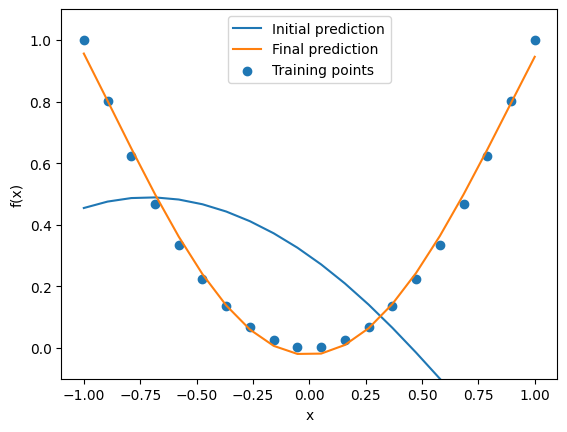

In [32]:
y_pred_final = model.expectation({"x": x_train}).squeeze().detach()

plt.plot(x_train, y_pred_initial, label = "Initial prediction")
plt.plot(x_train, y_pred_final, label = "Final prediction")
plt.scatter(x_train, y_train, label = "Training points")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.xlim((-1.1, 1.1))
plt.ylim((-0.1, 1.1))

## Conclusion

And voila!!... Hmm not quite perfect, but it kind of matches the data right?

Maybe with a few more qubits, a few more trainable parameters...

Well anyway, in this tutorial we have gone through the essential things you need to use Qadence. Now take a deep breath, read the instructions carefully, and you are set!

Best of luck,

The PQHack team.

# EXTRA:

## QNN vs QuantumModel

In the documentation you may see the `QNN` being used. This is simply a more specific `QuantumModel` where the `forward()` method directly calls the `expectation`, and it has a few other convenience functionalities. You are welcome to use it if you wish, but you can also stick to using `QuantumModel` as we did in this tutorial.

## Gradient-free optimization with Scipy

It's possible to train a Qadence model using `scipy.optimize.minimize`, which does not require gradients. To do so, you will need to write something following the syntax below:

In [ ]:
from scipy.optimize import minimize

# Defining the Qadence model as usual
model = QuantumModel(...)

# Defining a loss function with the scipy syntax
def loss_fn(params, *args):
    """Loss function written with the syntax needed for `minimize`."""
    # The model and the input values come as the extra arguments
    model, inputs = args
    # The params are being optimized by scipy, which you need to manually override in the model
    model.reset_vparams(torch.tensor(params))

    #############################
    # Perform your calculations #

    loss = ...
    
    #############################

    # Detach any gradients from the loss so scipy can convert the value
    return loss.detach()

# Define training parameters

n_params = len(model.vparams)

t_train = ...  # Training points
x0 = ...       # Initial guess for the params

res = minimize(loss_fn, x0 = x0, args = (model, t_train))

# Once the minimization is complete, reset again the model parameters with the final solution
model.reset_vparams(res.x)

## An unsolved bug you can easily go around

A bug will occur as described in the code below. It will complain about a mistmatch in tensor dimensions. Unfortunately we did not have the time to properly look into this before the hackathon. If you encounter it you can easily circumvent it by multiplying the feature parameter by 1.0.

In [33]:
import torch
from qadence import RX, FeatureParameter, run

# param = FeatureParameter("t") # GIVES BUG

param = 1.0 * FeatureParameter("t") # DOES NOT GIVE BUG

op = RX(0, param)

run(op, values = {"t": torch.tensor([[0.1]])})

tensor([[0.9988+0.0000j, 0.0000-0.0500j]])

If you use the `feature_map` function, you can do this automatically with the `multiplier` argument.

In [34]:
import torch
from qadence import feature_map, run

op = feature_map(n_qubits = 2, param = "t", multiplier = 1.0)

run(op, values = {"t": torch.tensor([[0.1]])})

tensor([[ 0.9975+0.0000j,  0.0000-0.0499j,  0.0000-0.0499j, -0.0025+0.0000j]])